#Predição do gênero de uma música a partir da letra

###Esse projeto tem como objetivo construir um modelo que prevê o gênero de uma música a partir da letra dela, utilizando um modelo de Processamento de Linguagem Natural (PLN), ou em ingles Natural Language Processing (NLP), e o dataset abaixo:
https://www.kaggle.com/neisse/scrapped-lyrics-from-6-genres

###Esse dataset contêm dois arquivos. O primeiro, artists-data, contém as seguintes colunas:
- Artists (nome do artista)
- Songs (quantidade de musicas)
- Popularity (nota de popularidade)
- Link (link da página do artista)
- Genre (gênero principal)
- Genres (gêneros que o artista de encaixa)

###O segundo dataset, lyrics-data, contém as seguintes colunas:
- ALink (link da página do artista)
- SName (nome da música)
- SLink (link da página da música)
- Lyric (letra da música)
- Idiom (idioma da música)

Primeiro faremos a conexão com o Google Drive.

In [3]:
from google.colab import drive
drive.mount('/content/drive')
caminho_drive = '/content/drive/My Drive/colab/NLP/T2/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Depois vamos importar as bibliotecas que serão utilizadas ao longo do código.

In [4]:
import pandas as pd
import nltk
nltk.download( 'popular' )
nltk.download( 'rslp' )
from nltk.stem import RSLPStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import multilabel_confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time
agora = str( datetime.now() - timedelta(hours = 3) ).replace(' ', '_').replace('-', '').replace(':', '')[:15] #horario de brasilia UTC-3
caminho_export = '{0}{1}_'.format( caminho_drive, agora )

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

Using TensorFlow backend.


Podemos agora importar os arquivos que serão utilizados.

In [ ]:
artistas = pd.read_csv( caminho_drive + 'artists-data.csv' )
artistas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3242 entries, 0 to 3241
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Artist      3242 non-null   object 
 1   Songs       3242 non-null   int64  
 2   Popularity  3242 non-null   float64
 3   Link        3242 non-null   object 
 4   Genre       3242 non-null   object 
 5   Genres      3238 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 152.1+ KB


In [ ]:
artistas.head()

,Artist,Songs,Popularity,Link,Genre,Genres
0,10000 Maniacs,110,0.3,/10000-maniacs/,Rock,Rock; Pop; Electronica; Dance; J-Pop/J-Rock; G...
1,12 Stones,75,0.3,/12-stones/,Rock,Rock; Gospel/Religioso; Hard Rock; Grunge; Roc...
2,311,196,0.5,/311/,Rock,Rock; Surf Music; Reggae; Ska; Pop/Rock; Rock ...
3,4 Non Blondes,15,7.5,/4-non-blondes/,Rock,Rock; Pop/Rock; Rock Alternativo; Grunge; Blue...
4,A Cruz Está Vazia,13,0.0,/a-cruz-esta-vazia/,Rock,Rock


In [ ]:
letras = pd.read_csv( caminho_drive + 'lyrics-data.csv' )
letras.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209522 entries, 0 to 209521
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   ALink   209522 non-null  object
 1   SName   209522 non-null  object
 2   SLink   209522 non-null  object
 3   Lyric   209484 non-null  object
 4   Idiom   206375 non-null  object
dtypes: object(5)
memory usage: 8.0+ MB


In [ ]:
letras.head()

,ALink,SName,SLink,Lyric,Idiom
0,/10000-maniacs/,More Than This,/10000-maniacs/more-than-this.html,I could feel at the time. There was no way of ...,ENGLISH
1,/10000-maniacs/,Because The Night,/10000-maniacs/because-the-night.html,"Take me now, baby, here as I am. Hold me close...",ENGLISH
2,/10000-maniacs/,These Are Days,/10000-maniacs/these-are-days.html,These are. These are days you'll remember. Nev...,ENGLISH
3,/10000-maniacs/,A Campfire Song,/10000-maniacs/a-campfire-song.html,"A lie to say, ""O my mountain has coal veins an...",ENGLISH
4,/10000-maniacs/,Everyday Is Like Sunday,/10000-maniacs/everyday-is-like-sunday.html,Trudging slowly over wet sand. Back to the ben...,ENGLISH


Com os arquivos importados, temos que manipular eles para juntar os dois arquivos e filtrar apenas as colunas necessárias para o projeto.

In [ ]:
#filtro das colunas
artistas = artistas[['Artist', 'Link', 'Genre']]
letras = letras[['ALink', 'SName', 'Lyric', 'Idiom']]

#inner join das colunas
dataset = pd.merge( artistas, letras, left_on='Link', right_on='ALink' )
dataset = dataset[['Artist', 'Genre', 'SName', 'Lyric', 'Idiom']]
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 227513 entries, 0 to 227512
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Artist  227513 non-null  object
 1   Genre   227513 non-null  object
 2   SName   227513 non-null  object
 3   Lyric   227474 non-null  object
 4   Idiom   223997 non-null  object
dtypes: object(5)
memory usage: 10.4+ MB


In [ ]:
dataset.head()

,Artist,Genre,SName,Lyric,Idiom
0,10000 Maniacs,Rock,More Than This,I could feel at the time. There was no way of ...,ENGLISH
1,10000 Maniacs,Rock,Because The Night,"Take me now, baby, here as I am. Hold me close...",ENGLISH
2,10000 Maniacs,Rock,These Are Days,These are. These are days you'll remember. Nev...,ENGLISH
3,10000 Maniacs,Rock,A Campfire Song,"A lie to say, ""O my mountain has coal veins an...",ENGLISH
4,10000 Maniacs,Rock,Everyday Is Like Sunday,Trudging slowly over wet sand. Back to the ben...,ENGLISH


Vamos agora ver quais são os gêneros das músicas do dataset.

In [ ]:
labels = dataset['Genre'].unique()
labels

array(['Rock', 'Pop', 'Hip Hop', 'Sertanejo', 'Samba', 'Funk Carioca'],
      dtype=object)

Podemos ver que temos 6 gêneros, e com isso criaremos um dicionário para criar uma coluna de numeração a partir dos gêneros em formato de texto.

In [ ]:
dataset_generos = { 'Rock':0, 'Pop':1, 'Hip Hop':2, 'Sertanejo':3, 'Samba':4, 'Funk Carioca':5 }
dataset_generos_rev = { 0:'Rock', 1:'Pop', 2:'Hip Hop', 3:'Sertanejo', 4:'Samba', 5:'Funk Carioca' }
dataset['NR_Genre'] = dataset['Genre']
dataset['NR_Genre'].replace( dataset_generos, inplace=True )

dataset.head()

,Artist,Genre,SName,Lyric,Idiom,NR_Genre
0,10000 Maniacs,Rock,More Than This,I could feel at the time. There was no way of ...,ENGLISH,0
1,10000 Maniacs,Rock,Because The Night,"Take me now, baby, here as I am. Hold me close...",ENGLISH,0
2,10000 Maniacs,Rock,These Are Days,These are. These are days you'll remember. Nev...,ENGLISH,0
3,10000 Maniacs,Rock,A Campfire Song,"A lie to say, ""O my mountain has coal veins an...",ENGLISH,0
4,10000 Maniacs,Rock,Everyday Is Like Sunday,Trudging slowly over wet sand. Back to the ben...,ENGLISH,0


Com o dataset no formato que queremos, devemos agora definir uma língua que iremos utilizar em toda nossa análise.

In [ ]:
dataset['Idiom'].value_counts()[:5]

ENGLISH       124230
PORTUGUESE     93125
SPANISH         4950
ITALIAN          635
FRENCH           407
Name: Idiom, dtype: int64

Podemos ver que a maior parte dos dados estão em inglês e em português. Vamos então criar dois datasets para analisá-los separadamente.

In [ ]:
dataset_pt = dataset[dataset['Idiom'] == 'PORTUGUESE']
dataset_pt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93125 entries, 387 to 227512
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Artist    93125 non-null  object
 1   Genre     93125 non-null  object
 2   SName     93125 non-null  object
 3   Lyric     93125 non-null  object
 4   Idiom     93125 non-null  object
 5   NR_Genre  93125 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 5.0+ MB


In [ ]:
dataset_pt.head()

,Artist,Genre,SName,Lyric,Idiom,NR_Genre
387,311,Rock,Summer Of Love - Traducao,Eu pensei na minha cena hoje. E eu finalmente ...,PORTUGUESE,0
542,311,Rock,Summer Of Love - Traducao,Eu pensei na minha cena hoje. E eu finalmente ...,PORTUGUESE,0
611,A Cruz Está Vazia,Rock,A Cruz Está Vazia,A Cruz esta vazia. Morreu em meu lugar para me...,PORTUGUESE,0
612,A Cruz Está Vazia,Rock,A Minha Vida,Queria gritar para o mundo todo o quanto eu te...,PORTUGUESE,0
613,A Cruz Está Vazia,Rock,Amor Eterno,Por que longe de você eu fico triste?. Você ch...,PORTUGUESE,0


In [ ]:
dataset_en = dataset[dataset['Idiom'] == 'ENGLISH']
dataset_en.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124230 entries, 0 to 225914
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Artist    124230 non-null  object
 1   Genre     124230 non-null  object
 2   SName     124230 non-null  object
 3   Lyric     124230 non-null  object
 4   Idiom     124230 non-null  object
 5   NR_Genre  124230 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 6.6+ MB


In [ ]:
dataset_en.head()

,Artist,Genre,SName,Lyric,Idiom,NR_Genre
0,10000 Maniacs,Rock,More Than This,I could feel at the time. There was no way of ...,ENGLISH,0
1,10000 Maniacs,Rock,Because The Night,"Take me now, baby, here as I am. Hold me close...",ENGLISH,0
2,10000 Maniacs,Rock,These Are Days,These are. These are days you'll remember. Nev...,ENGLISH,0
3,10000 Maniacs,Rock,A Campfire Song,"A lie to say, ""O my mountain has coal veins an...",ENGLISH,0
4,10000 Maniacs,Rock,Everyday Is Like Sunday,Trudging slowly over wet sand. Back to the ben...,ENGLISH,0


Separado os datasets, vamos analisar como está a distribuição dos gêneros para cada um deles.

In [ ]:
dataset_pt['Genre'].value_counts()

Sertanejo       34919
Pop             15082
Samba           15044
Rock            13600
Funk Carioca     8086
Hip Hop          6394
Name: Genre, dtype: int64

Vendo a quantidade de cada um dos gêneros da língua portuguesa, percebemos que eles estão relativamente bem distribuidos, então por enquanto deixaremos assim.

In [ ]:
dataset_en['Genre'].value_counts()

Rock            60585
Pop             40294
Hip Hop         23108
Funk Carioca      104
Sertanejo          87
Samba              52
Name: Genre, dtype: int64

Já na língua inglesa, vemos que os gêneros de Funk Carioca, Sertanejo e Samba não tem muitos dados, que faz sentido por serem gêneros brasileiros, e por conta disso vamos retirar esses gêneros desse dataset.

In [ ]:
dataset_en = dataset_en[(dataset_en['Genre'] == 'Rock') | (dataset_en['Genre'] == 'Pop') | (dataset_en['Genre'] == 'Hip Hop')]
dataset_en.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123987 entries, 0 to 225066
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Artist    123987 non-null  object
 1   Genre     123987 non-null  object
 2   SName     123987 non-null  object
 3   Lyric     123987 non-null  object
 4   Idiom     123987 non-null  object
 5   NR_Genre  123987 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 6.6+ MB


In [ ]:
dataset_en['Genre'].value_counts()

Rock       60585
Pop        40294
Hip Hop    23108
Name: Genre, dtype: int64

In [ ]:
quantidade_generos_pt = 6
quantidade_generos_en = 3

Com os datasets já trabalhados, vamos começar a criar nossa PNL, primeiro focando no dataset em português.

Primeira coisa que faremos é criar uma lista de todas as palavras das letras musicais.

In [ ]:
letras_pt_agrupado = ''
for i in range( dataset_pt.shape[0] ):
    letras_pt_agrupado += dataset_pt.iloc[i]['Lyric']

w_token_pt = word_tokenize( letras_pt_agrupado )
w_token_pt[:5]

['Eu', 'pensei', 'na', 'minha', 'cena']

Segundo vamos retirar algumas palavras que não ajudam muito o nosso algoritmo, chamadas "stopwords", ou em português "palavras vazias", juntamente com as pontuações e caracteres especiais, dimiuindo a quantidade de entradas do algoritmo.

In [ ]:
stw_pt = stopwords.words('portuguese')

stw_pt[:5]

['de', 'a', 'o', 'que', 'e']

In [ ]:
pontuacao = list( punctuation )

pontuacao[:5]

['!', '"', '#', '$', '%']

In [ ]:
stopwords_pt = set( stw_pt + pontuacao ) #cria lista sem repetir elementos

list(stopwords_pt)[:5]

['_', 'tuas', ';', 'até', 'nossas']

In [ ]:
w_token_pt_sem_stopwords = [palavra for palavra in w_token_pt if palavra not in stopwords_pt]

w_token_pt_sem_stopwords[:5]

['Eu', 'pensei', 'cena', 'hoje', 'E']

Terceiro vamos encurtar certas palavras para serem interpretadas pelo nosso código como significando a mesma coisa, com objetivo de dimiuir a quantidade de entradas do nosso algoritmo, e facilitar o entendimento da língua.

Ex: 'pegar', 'peguei', 'pegamos' e 'pegaremos' podem ser transformados em 'pegar'.

In [ ]:
stemmer = RSLPStemmer()

w_token_pt_sem_stopwords_stem = [stemmer.stem( palavra ) for palavra in w_token_pt_sem_stopwords]

w_token_pt_sem_stopwords_stem[:5]

['eu', 'pens', 'cen', 'hoj', 'e']

Com nossas palavras todas prontas vamos criar um dicionário com todas essas palavras, para podermos traduzir nossas entradas no formato que o modelo vai aceitar.

In [16]:
vectorizer_pt = CountVectorizer( analyzer='word' )

vectorizer_pt.fit( w_token_pt_sem_stopwords_stem )

tamanho_dicionario_pt = len(vectorizer_pt.vocabulary_)
print( 'Quantidade de palavras no dicionário = {0}'.format( tamanho_dicionario_pt ) )

Quantidade de palavras no dicionário = 92322


Agora que já temos nosso dicionário de palavras, podemos começar a preparar os dados de entrada e saída do modelo.

Primeiro vamos separar entre dados de entrada e saída.

In [ ]:
letras_pt = dataset_pt['Lyric'].values #X
generos_pt = dataset_pt['NR_Genre'].values #Y

print( 'Formato de dados de entrada = {0}'.format(letras_pt.shape) )
print( 'Formato de dados de saída   = {0}'.format(generos_pt.shape) )

Vamos transformar nossa saída em um vetor dummy, ou seja, a saída [0] vai ser transformada em [1, 0, 0, 0, 0, 0], a saída [1] vai ser transformada em [0, 1, 0, 0, 0, 0, 0], e assim por diante.

In [ ]:
generos_pt_dummy = np_utils.to_categorical(generos_pt)

generos_pt_dummy[:5]

Com os dados separados entre entrada e saída, vamos separar os dados entre treino, validação e teste.

Usaremos inicialmente 70% dos dados para treino, 15% para validação e 15% para teste.

In [ ]:
x_treino_pt, x_teste_pt, y_treino_pt, y_teste_pt = train_test_split( letras_pt, generos_pt_dummy, test_size=0.3, random_state=42 )
x_vali_pt, x_teste_pt, y_vali_pt, y_teste_pt = train_test_split( x_teste_pt, y_teste_pt, test_size=0.5, random_state=42 )

print('Formato de dados de entrada para treino    = {0}'.format(x_treino_pt.shape))
print('Formato de dados de entrada para validação = {0}'.format(x_vali_pt.shape))
print('Formato de dados de entrada para teste     = {0}'.format(x_teste_pt.shape))
print('Formato de dados de saída para treino      = {0}'.format(y_treino_pt.shape))
print('Formato de dados de saída para validação   = {0}'.format(y_vali_pt.shape))
print('Formato de dados de saída para teste       = {0}'.format(y_teste_pt.shape))

Devemos transformar os dados de entrada no formato do vetor de palavras, e para isso usaremos o dicionário que criamos anteriormente.

In [ ]:
BOW_x_treino_pt = vectorizer_pt.transform( x_treino_pt )
BOW_x_vali_pt = vectorizer_pt.transform( x_vali_pt )
BOW_x_teste_pt = vectorizer_pt.transform( x_teste_pt )

print('Formato do vetor de palavras para treino    = {0}'.format(BOW_x_treino_pt.shape))
print('Formato do vetor de palavras para validação = {0}'.format(BOW_x_vali_pt.shape))
print('Formato do vetor de palavras para teste     = {0}'.format(BOW_x_teste_pt.shape))

Com todos os dados manipulados e separados para o modelo, vamos criar nosso primeiro modelo, com a entrada dele sendo o tamanho do nosso dicionário de palavras, e a saída a quantidade de gêneros da língua.

In [ ]:
modelo_pt = Sequential()

modelo_pt.add( Dense( 128, activation='relu', input_shape=(tamanho_dicionario_pt,) ) )
modelo_pt.add( Dense( quantidade_generos_pt, activation='softmax' ) )

modelo_pt.compile( Adam(), loss='categorical_crossentropy', metrics=['accuracy'] )

modelo_pt.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               11817344  
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 774       
Total params: 11,818,118
Trainable params: 11,818,118
Non-trainable params: 0
_________________________________________________________________


E com nosso modelo pronto, podemos finalmente treinar ele.

Com um primeiro modelo, colocaremos para ele rodar todos os dados de treino por 50 vezes e analisaremos o resultado.

In [ ]:
historico_pt = modelo_pt.fit( BOW_x_treino_pt, y_treino_pt, epochs=50, validation_data=( BOW_x_vali_pt, y_vali_pt ) )

Epoch 1/50
2038/2038 [==============================] - 82s 40ms/step - loss: 1.0813 - accuracy: 0.6140 - val_loss: 0.9679 - val_accuracy: 0.6496
Epoch 2/50
2038/2038 [==============================] - 78s 38ms/step - loss: 0.7458 - accuracy: 0.7251 - val_loss: 0.9539 - val_accuracy: 0.6640
Epoch 3/50
2038/2038 [==============================] - 78s 38ms/step - loss: 0.5704 - accuracy: 0.7883 - val_loss: 0.9934 - val_accuracy: 0.6711
Epoch 4/50
2038/2038 [==============================] - 78s 38ms/step - loss: 0.4695 - accuracy: 0.8227 - val_loss: 1.0723 - val_accuracy: 0.6689
Epoch 5/50
2038/2038 [==============================] - 74s 36ms/step - loss: 0.4019 - accuracy: 0.8451 - val_loss: 1.1086 - val_accuracy: 0.6694
Epoch 6/50
2038/2038 [==============================] - 74s 36ms/step - loss: 0.3620 - accuracy: 0.8584 - val_loss: 1.1902 - val_accuracy: 0.6728
Epoch 7/50
2038/2038 [==============================] - 74s 36ms/step - loss: 0.3335 - accuracy: 0.8646 - val_loss: 1.2315 -

Com o modelo treinado, vamos analisar como a função de custo e a métrica de exatidão se comportaram durante o treino, para as informações de treino e validação.

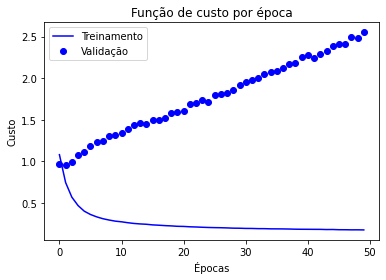

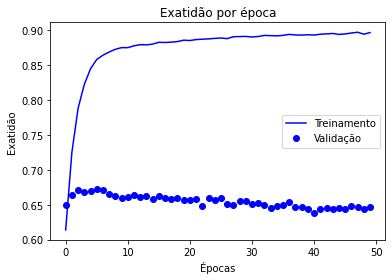

In [ ]:
plt.plot(historico_pt.history['loss'], 'b', label='Treinamento')
plt.plot(historico_pt.history['val_loss'], 'bo', label='Validação')
plt.title('Função de custo por época')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()

plt.plot(historico_pt.history['accuracy'], 'b', label='Treinamento')
plt.plot(historico_pt.history['val_accuracy'], 'bo', label='Validação')
plt.title('Exatidão por época')
plt.xlabel('Épocas')
plt.ylabel('Exatidão')
plt.legend()
plt.show()

Podemos analisar que o modelo deu overfit, onde ele melhora os resultados do modelo para o treino ao longo das épocas, mas piorando os o modelo para os dados de validação ao longo das épocas.

In [ ]:
desempenho_treino_pt = modelo_pt.evaluate( BOW_x_treino_pt, y_treino_pt )
print('Valor da função de custo do treino = {0:.4f}\nValor da exatidão do treino = {1:.4f}'.format( desempenho_treino_pt[0], desempenho_treino_pt[1] ))

desempenho_validacao_pt = modelo_pt.evaluate( BOW_x_vali_pt, y_vali_pt )
print('Valor da função de custo da validação = {0:.4f}\nValor da exatidão da validação = {1:.4f}'.format( desempenho_validacao_pt[0], desempenho_validacao_pt[1] ))

desempenho_teste_pt = modelo_pt.evaluate( BOW_x_teste_pt, y_teste_pt )
print('Valor da função de custo do teste = {0:.4f}\nValor da exatidão do teste = {1:.4f}'.format( desempenho_teste_pt[0], desempenho_teste_pt[1] ))

2038/2038 [==============================] - 3s 1ms/step - loss: 0.1599 - accuracy: 0.9070
Valor da função de custo do treino = 0.1599
Valor da exatidão do treino = 0.9070
437/437 [==============================] - 1s 1ms/step - loss: 2.5529 - accuracy: 0.6471
Valor da função de custo da validação = 2.5529
Valor da exatidão da validação = 0.6471
437/437 [==============================] - 1s 1ms/step - loss: 2.6337 - accuracy: 0.6500
Valor da função de custo do teste = 2.6337
Valor da exatidão do teste = 0.6500


In [ ]:
y_pred_pt = modelo_pt.predict( BOW_x_teste_pt )
y_pred_pt = np.round(y_pred_pt)

conf_matrix_pt = multilabel_confusion_matrix(y_teste_pt, y_pred_pt)
conf_matrix_pt

array([[[11143,   715],
        [  904,  1207]],

       [[10769,   985],
        [ 1440,   775]],

       [[12720,   265],
        [  366,   618]],

       [[ 7317,  1415],
        [ 1060,  4177]],

       [[11129,   605],
        [  749,  1486]],

       [[12353,   429],
        [  621,   566]]])

In [ ]:
# Legião Urbana - Tempo perdido
musica_teste_pt_rock = 'Todos os dias quando acordo Não tenho mais O tempo que passou Mas tenho muito tempo Temos todo o tempo do mundo Todos os dias Antes de dormir Lembro e esqueço Como foi o dia Sempre em frente Não temos tempo a perder Nosso suor sagrado É bem mais belo Que esse sangue amargo E tão sério E selvagem! Selvagem! Selvagem! Veja o sol Dessa manhã tão cinza A tempestade que chega É da cor dos teus olhos Castanhos Então me abraça forte E diz mais uma vez Que já estamos Distantes de tudo Temos nosso próprio tempo Temos nosso próprio tempo Temos nosso próprio tempo Não tenho medo do escuro Mas deixe as luzes Acesas agora O que foi escondido É o que se escondeu E o que foi prometido Ninguém prometeu Nem foi tempo perdido Somos tão jovens Tão jovens! Tão jovens!'

# Lexa - Amor bandido
musica_teste_pt_pop = 'Oh oh oh oh yeah yeah yeah yeah yeah yeah Lexa e Kekel Hitmaker Sei que você tá bolada Tá chateada e não quer me ouvir Dei umas escorregada Uma vacilada e me arrependi Mas to aqui, bebê Pedindo pra você voltar comigo Voltar comigo Eu te falei que não tinha perdão E pro meu coração já não dava mais Só que foi batendo a bad O corpo pede, voltei atrás Mas to aqui, bebê Sorrindo pra você voltar comigo Voltar comigo Voltar comigo Baby, eu não resisto a esse nosso amor bandido Quando você beija meu pescoço até o umbigo Volta pra cá que a saudade tá pedindo Baby, vem cá Baby, eu não resisto a esse nosso amor bandido Quando você beija meu pescoço até o umbigo Volta pra cá que a saudade tá pedindo Baby, vem cá Você sabe que é maldade Despertar minha insanidade To morrendo de vontade da sua boca Agora vê se não vacila Volta pra minha vida e vê se fica sem roupa Incrível como tudo se encaixa Em tudo o que a gente faz Indescritível o sentimento permanente que você me traz Baby, eu não resisto a esse nosso amor bandido Quando você beija meu pescoço até o umbigo Volta pra cá que a saudade tá pedindo Baby, vem cá Baby, eu não resisto a esse nosso amor bandido Quando você beija meu pescoço até o umbigo Volta pra cá que a saudade tá pedindo Baby, vem cá Eu to querendo mais Eu to querendo mais Cê tá querendo, eu to querendo Então como é que faz? Eu to querendo mais Eu to querendo mais Cê tá querendo, eu to querendo Então como é que faz? Eu to querendo mais Eu to querendo mais Cê tá querendo, eu to querendo Então como é que faz? Eu to querendo mais Eu to querendo mais Cê tá querendo Baby, eu não resisto a esse nosso amor bandido Quando você beija meu pescoço até o umbigo Volta pra cá que a saudade tá pedindo Baby, vem cá Eu to querendo mais Então como é que faz? Kekel e Lexa (yeah yeah yeah yeah)'

# 1Kilo - Deixe-me ir
musica_teste_pt_hiphop = 'Menina, me dá sua mão, pense bem antes de agir Se não for agora, te espero lá fora, então deixe-me ir Um dia te encontro nessas suas voltas Minha mente é mó confusão Solta a minha mão, que eu sei que cê volta O tempo mostra nossa direção Se eu soubesse que era assim, eu nem vinha Tô bebendo champanhe e catando latinha Mas tive que perder pra aprender dar valor Pra você entender seu amor, mas não quer ser mais minha Então diz que não me quer por perto Mas diz olhando nos meus olhos Desculpe se eu não fui sincero Mas a vida que eu levo, erros lógicos Óbvio, cada letra em rap é um código sórdido Psicografado som sólido, súbito Nunca fui de fazer som pra público Verso meu universo, peço que entenda meu mundo, mina A gente briga por bobeira demais A gente pira, o tempo vira por bobeira demais O amor é bandeira de paz Mas se não der, vai em paz, meto o pé Tô vivo e quero viver, ensinar e aprender Menina, eu sigo com ou sem você, mas tente entender Eu tentei, a vida é curta pra chorar pela ex Eu falei pra mim mesmo enquanto eu chorava outra vez, é Eu vou ficar, mas vou pela manhã Sem me despedir, vou antes do café Que é pra não te acordar, sei que não sou nenhum Don Juan Sou todo errado, mas tô certo que você me quer Eu vou ficar, mas vou pela manhã Sem me despedir, vou antes do café Que é pra não te acordar, sei que não sou nenhum Don Juan Sou todo errado, mas tô certo que você me quer Ei, amor, sei que tá tão difícil eu falar de amor Porque lá fora é tanto ódio e rancor Que eu preciso muito te falar Ei, amor, eu tô contigo independente do caô Cê sabe que aonde você for, eu vou E já passou da hora da gente se encontrar E se amar, nega, cê sabe que contigo nada vai me abalar A viagem é longa, então faça a mala Na vibe mais positiva, no pique mandala Esse papo de que se tu não existisse eu te inventaria é tão clichê Mas cai tão bem quando se trata de você Só vem comigo, cê não vai se arrepender Só vem comigo, cê não vai se arrepender Noites em claro, tentando não me envolver Seja o que deus quiser Noites em claro, tentando não me envolver Seja o que deus quiser, deixe-me ir Não vou me despedir porque dói Não vou brigar pra ficar Quero estar contigo e sentir, ser seu e só Sem ter que justificar o tempo em que eu sumi Seja o que deus quiser, deixe-me ir'

# Henrique & Juliano - Amor atual
musica_teste_pt_sertanejo = 'Você não pensou no meu amor Foi tão covarde Vivi um drama Vivendo na lama Já to indo tarde Não quero isso pra mim Não vou viver assim Eita, como dói Isso me destrói Mas eu vou te falar Você tá pensando o quê? Seu amor atual não tem culpa do anterior, bebê Tá pensando o quê? O que ele fez contigo, comigo cê quer fazer Você tá pensando o quê? Seu amor atual não tem culpa do anterior, bebê Tá pensando o quê? O que ele fez contigo, comigo cê quer fazer Pode esquecer Aí a pessoa briga com a pessoa E a pessoa quer brigar com a minha pessoa Tem jeito não, né Aí, não, né Você não pensou no meu amor Foi tão covarde Vivi um drama Vivendo na lama Já to indo tarde Não quero isso pra mim Não vou viver assim Eita, como dói Isso me destrói Mas eu vou te falar Você tá pensando o quê? Seu amor atual não tem culpa do anterior, bebê Tá pensando o quê? O que ele fez contigo, comigo cê quer fazer Você tá pensando o quê? Seu amor atual não tem culpa do anterior, bebê Tá pensando o quê? O que ele fez contigo, comigo cê quer fazer Pode esquecer Você tá pensando o quê? Seu amor atual não tem culpa do anterior, bebê Tá pensando o quê? O que ele fez contigo, comigo cê quer fazer Você tá pensando o quê? Seu amor atual não tem culpa do anterior, bebê Tá pensando o quê? O que ele fez contigo, comigo cê quer fazer Pode esquecer'

# Martinho Da Vila - Casa de Bamba
musica_teste_pt_samba = 'Na minha casa Todo mundo é bamba Todo mundo bebe Todo mundo samba Na minha casa Todo mundo é bamba Todo mundo bebe Todo mundo samba Na minha casa Não tem bola pra vizinha Não se fala do alheio Nem se liga pra candinha Na minha casa Não tem bola pra vizinha Não se fala do alheio Nem se liga pra candinha Na minha casa Todo mundo é bamba Todo mundo bebe Todo mundo samba Na minha casa Todo mundo é bamba Todo mundo bebe Todo mundo samba Na minha casa Ninguém liga pra intriga Todo mundo xinga Todo mundo briga Na minha casa Ninguém liga prá intriga Todo mundo xinga Todo mundo briga Macumba lá na minha casa Tem galinha preta Azeite de dendê Mas ladainha lá na minha casa Tem reza bonitinha E canjiquinha pra comer Mas ladainha lá na minha casa Tem reza bonitinha E canjiquinha pra comer Se tem alguém aflito Todo mundo chora Todo mundo sofre Mas logo se reza Pra São Benedito Pra Nossa Senhora E pra Santo Onofre Mas se tem alguém cantando Todo mundo canta Todo mundo dança Todo mundo samba E ninguém se cansa Pois minha casa É casa de bamba Pois minha casa É casa de bamba Macumba lá na minha casa Tem galinha preta Azeite de dendê Mas ladainha lá na minha casa Tem reza bonitinha E canjiquinha prá comer Mas ladainha lá na minha casa Tem reza bonitinha E canjiquinha pra comer Se tem alguém aflito Todo mundo chora Todo mundo sofre Mas logo se reza Pra São Benedito Pra Nossa Senhora E pra Santo Onofre Mas se tem alguém cantando Todo mundo canta Todo mundo dança Todo mundo samba E ninguém se cansa Pois minha casa É casa de bamba Pois minha casa É casa de bamba Pois minha casa É casa de bamba'

# MC Ingryd - Vem Me Satisfazer
musica_teste_pt_funk = 'Marca pra nós se ver Pode ser pra ferver Hoje eu quero você Vem me satisfazer No teu jeito que eu me amarro De quatro, eu jogo o rabo Sequência de toma-toma Sequência de vapo-vapo De quatro, eu jogo o rabo De quatro, eu jogo o rabo Sequência de toma-toma Sequência de vapo-vapo De quatro, eu jogo o rabo De quatro, eu jogo o rabo Sequência de toma-toma Sequência de vapo-vapo De quatro, eu jogo o rabo De quatro, eu jogo o rabo Sequência de toma-toma Sequência de vapo-vapo De quatro, eu jogo o rabo De quatro, eu jogo o rabo Sequência de toma-toma Sequência de vapo-vapo Te avisei, não se envolve no meu papo Não passou de um boato pra você enlouquecer Eu te dei prazer, tu pediu prazer Agora o que eu posso fazer? Eu não quero mais você Quem falou que eu quero ser tua mulher? Toma vergonha na cara e vê se larga do meu pé Muito louca na onda do Goldin Chamei os cria pra base Vai rolar chuva de lean De quatro, eu jogo o rabo De quatro, eu jogo o rabo Sequência de toma-toma Sequência de vapo-vapo De quatro, eu jogo o rabo De quatro, eu jogo o rabo Sequência de toma-toma Sequência de vapo-vapo De quatro, eu jogo o rabo De quatro, eu jogo o rabo Sequência de toma-toma Sequência de vapo-vapo De quatro, eu jogo o rabo De quatro, eu jogo o rabo Sequência de toma-toma Sequência de vapo-vapo Marca pra nós se ver Pode ser pra ferver Hoje eu quero você Vem me satisfazer No teu jeito que eu me amarro De quatro, eu jogo o rabo Sequência de toma-toma Sequência de vapo-vapo De quatro, eu jogo o rabo De quatro, eu jogo o rabo Sequência de toma-toma Sequência de vapo-vapo De quatro, eu jogo o rabo De quatro, eu jogo o rabo Sequência de toma-toma Sequência de vapo-vapo De quatro, eu jogo o rabo De quatro, eu jogo o rabo Sequência de toma-toma Sequência de vapo-vapo De quatro, eu jogo o rabo De quatro, eu jogo o rabo Sequência de toma-toma Sequência de vapo-vapo Te avisei, não se envolve no meu papo Não passou de um boato pra você enlouquecer Eu te dei prazer, tu pediu prazer Agora o que eu posso fazer? Eu não quero mais você Quem falou que eu quero ser tua mulher? Toma vergonha na cara e vê se larga do meu pé Muito louca na onda do Goldin Chamei os cria pra base Vai rolar chuva de lean De quatro, eu jogo o rabo De quatro, eu jogo o rabo Sequência de toma-toma Sequência de vapo-vapo De quatro, eu jogo o rabo De quatro, eu jogo o rabo Sequência de toma-toma Sequência de vapo-vapo De quatro, eu jogo o rabo De quatro, eu jogo o rabo Sequência de toma-toma Sequência de vapo-vapo De quatro, eu jogo o rabo De quatro, eu jogo o rabo Sequência de toma-toma Sequência de vapo-vapo'

lista_musicas_teste_pt = [ musica_teste_pt_rock, musica_teste_pt_pop, musica_teste_pt_hiphop, musica_teste_pt_sertanejo, musica_teste_pt_samba, musica_teste_pt_funk ]

teste_pt = vectorizer_pt.transform( lista_musicas_teste_pt ).toarray()
saida_teste_pt = modelo_pt.predict( teste_pt )
saida_teste_mex_pt = np.argmax( saida_teste_pt, axis=1 )
saida_teste_traducao_pt = [dataset_generos_rev.get(item,item) for item in saida_teste_mex_pt]

for i in range( quantidade_generos_pt ):
    print('Música de {0} o modelo preveu {1}'.format( list(dataset_generos.keys())[i], saida_teste_traducao_pt[i] ))

Música de Rock o modelo preveu Pop
Música de Pop o modelo preveu Pop
Música de Hip Hop o modelo preveu Pop
Música de Sertanejo o modelo preveu Sertanejo
Música de Samba o modelo preveu Samba
Música de Funk Carioca o modelo preveu Hip Hop


Com nosso modelo para a língua pra portuguesa treinado, vamos agora realizar as mesmas manipulções, e criar um modelo, mas agora para a língua inglesa.

In [ ]:
letras_en_agrupado = ''
for i in range( dataset_en.shape[0] ):
    letras_en_agrupado += dataset_en.iloc[i]['Lyric']

w_token_en = word_tokenize( letras_en_agrupado )
w_token_en[:5]

['I', 'could', 'feel', 'at', 'the']

In [ ]:
stw_en = stopwords.words('english')

stw_en[:5]

['i', 'me', 'my', 'myself', 'we']

In [ ]:
pontuacao = list( punctuation )

pontuacao[:5]

['!', '"', '#', '$', '%']

In [ ]:
stopwords_en = set( stw_en + pontuacao ) #cria lista sem repetir elementos

list(stopwords_en)[:5]

["hasn't", 'ma', 'hasn', "you'll", "it's"]

In [ ]:
w_token_en_sem_stopwords = [palavra for palavra in w_token_en if palavra not in stopwords_en]

w_token_en_sem_stopwords[:5]

['I', 'could', 'feel', 'time', 'There']

In [ ]:
stemmer = RSLPStemmer()

w_token_en_sem_stopwords_stem = [stemmer.stem( palavra ) for palavra in w_token_en_sem_stopwords]

w_token_en_sem_stopwords_stem[:5]

['i', 'could', 'feel', 'tim', 'ther']

In [ ]:
vectorizer_en = CountVectorizer( analyzer='word' )

vectorizer_en.fit( w_token_en_sem_stopwords_stem )

tamanho_dicionario_en = len(vectorizer_en.vocabulary_)
print( 'Quantidade de palavras no dicionário = {0}'.format( tamanho_dicionario_en ) )

Quantidade de palavras no dicionário = 


In [ ]:
letras_en = dataset_en['Lyric'].values #X
generos_en = dataset_en['NR_Genre'].values #Y

generos_en_dummy = np_utils.to_categorical(generos_en)

x_treino_en, x_teste_en, y_treino_en, y_teste_en = train_test_split( letras_en, generos_en_dummy, test_size=0.3, random_state=42 )
x_vali_en, x_teste_en, y_vali_en, y_teste_en = train_test_split( x_teste_en, y_teste_en, test_size=0.5, random_state=42 )

BOW_x_treino_en = vectorizer_en.transform( x_treino_en )
BOW_x_vali_en = vectorizer_en.transform( x_vali_en )
BOW_x_teste_en = vectorizer_en.transform( x_teste_en )

print('Formato do vetor de palavras para treino    = {0}'.format(BOW_x_treino_en.shape))
print('Formato do vetor de palavras para validação = {0}'.format(BOW_x_vali_en.shape))
print('Formato do vetor de palavras para teste     = {0}'.format(BOW_x_teste_en.shape))
print('Formato de dados de saída para treino       = {0}'.format(y_treino_en.shape))
print('Formato de dados de saída para validação    = {0}'.format(y_vali_en.shape))
print('Formato de dados de saída para teste        = {0}'.format(y_teste_en.shape))

Formato do vetor de palavras para treino    = (86790, 129314)
Formato do vetor de palavras para validação = (18598, 129314)
Formato do vetor de palavras para teste     = (18599, 129314)
Formato de dados de saída para treino       = (86790, 3)
Formato de dados de saída para validação    = (18598, 3)
Formato de dados de saída para teste        = (18599, 3)


In [ ]:
modelo_en = Sequential()

modelo_en.add( Dense( 128, activation='relu', input_shape=(tamanho_dicionario_en,) ) )
modelo_en.add( Dense( quantidade_generos_en, activation='softmax' ) )

modelo_en.compile( Adam(), loss='categorical_crossentropy', metrics=['accuracy'] )

modelo_en.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 128)               16552320  
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 387       
Total params: 16,552,707
Trainable params: 16,552,707
Non-trainable params: 0
_________________________________________________________________


In [ ]:
historico_en = modelo_en.fit( BOW_x_treino_en, y_treino_en, epochs=50, validation_data=( BOW_x_vali_en, y_vali_en ) )

Epoch 1/50
2713/2713 [==============================] - 167s 62ms/step - loss: 0.7210 - accuracy: 0.6784 - val_loss: 0.6803 - val_accuracy: 0.6893
Epoch 2/50
2713/2713 [==============================] - 167s 62ms/step - loss: 0.5835 - accuracy: 0.7323 - val_loss: 0.6659 - val_accuracy: 0.6969
Epoch 3/50
2713/2713 [==============================] - 167s 61ms/step - loss: 0.4985 - accuracy: 0.7719 - val_loss: 0.6863 - val_accuracy: 0.6998
Epoch 4/50
2713/2713 [==============================] - 164s 60ms/step - loss: 0.4344 - accuracy: 0.8015 - val_loss: 0.7393 - val_accuracy: 0.6914
Epoch 5/50
2713/2713 [==============================] - 164s 61ms/step - loss: 0.3858 - accuracy: 0.8237 - val_loss: 0.7816 - val_accuracy: 0.6945
Epoch 6/50
2713/2713 [==============================] - 164s 60ms/step - loss: 0.3555 - accuracy: 0.8379 - val_loss: 0.8231 - val_accuracy: 0.6909
Epoch 7/50
2713/2713 [==============================] - 164s 60ms/step - loss: 0.3309 - accuracy: 0.8474 - val_loss: 0

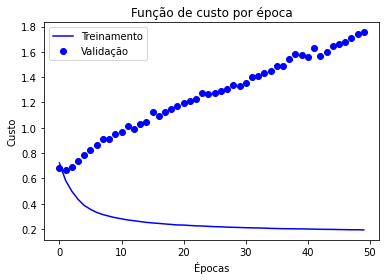

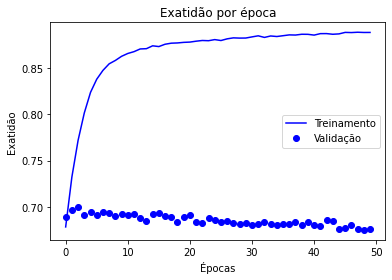

In [ ]:
plt.plot(historico_en.history['loss'], 'b', label='Treinamento')
plt.plot(historico_en.history['val_loss'], 'bo', label='Validação')
plt.title('Função de custo por época')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()

plt.plot(historico_en.history['accuracy'], 'b', label='Treinamento')
plt.plot(historico_en.history['val_accuracy'], 'bo', label='Validação')
plt.title('Exatidão por época')
plt.xlabel('Épocas')
plt.ylabel('Exatidão')
plt.legend()
plt.show()

Novamente podemos ver que o modelo deu overfit. é esperada essa performace pois temos muitos parâmetros na rede para um número não tao grande de dados.

In [ ]:
desempenho_treino_en = modelo_en.evaluate( BOW_x_treino_en, y_treino_en )
print('Valor da função de custo do treino = {0:.4f}\nValor da exatidão do treino = {1:.4f}'.format( desempenho_treino_en[0], desempenho_treino_en[1] ))

desempenho_validacao_en = modelo_en.evaluate( BOW_x_vali_en, y_vali_en )
print('Valor da função de custo da validação = {0:.4f}\nValor da exatidão da validação = {1:.4f}'.format( desempenho_validacao_en[0], desempenho_validacao_en[1] ))

desempenho_teste_en = modelo_en.evaluate( BOW_x_teste_en, y_teste_en )
print('Valor da função de custo do teste = {0:.4f}\nValor da exatidão do teste = {1:.4f}'.format( desempenho_teste_en[0], desempenho_teste_en[1] ))

2713/2713 [==============================] - 4s 1ms/step - loss: 0.1734 - accuracy: 0.9016
Valor da função de custo do treino = 0.1734
Valor da exatidão do treino = 0.9016
582/582 [==============================] - 1s 1ms/step - loss: 1.7547 - accuracy: 0.6761
Valor da função de custo da validação = 1.7547
Valor da exatidão da validação = 0.6761
582/582 [==============================] - 1s 1ms/step - loss: 1.6874 - accuracy: 0.6748
Valor da função de custo do teste = 1.6874
Valor da exatidão do teste = 0.6748


In [ ]:
y_pred_en = modelo_en.predict( BOW_x_teste_en )
y_pred_en = np.round(y_pred_en)

conf_matrix_en = multilabel_confusion_matrix(y_teste_en, y_pred_en)
conf_matrix_en

array([[[ 7236,  2281],
        [ 1780,  7302]],

       [[10204,  2373],
        [ 3117,  2905]],

       [[13915,  1189],
        [ 1312,  2183]]])

In [ ]:
# Linkin Park - Numb
musica_teste_en_rock = "I'm tired of being what you want me to be Feeling so faithless, lost under the surface I don't know what you're expecting of me Put under the pressure of walking in your shoes Caught in the undertow, just caught in the undertow Every step that I take is another mistake to you Caught in the undertow, just caught in the undertow I've become so numb, I can't feel you there Become so tired, so much more aware By becoming this all I want to do Is be more like me and be less like you Can't you see that you're smothering me? Holding too tightly, afraid to lose control 'Cause everything that you thought I would be Has fallen apart right in front of you Caught in the undertow, just caught in the undertow Every step that I take is another mistake to you Caught in the undertow, just caught in the undertow And every second I waste is more than I can take! I've become so numb, I can't feel you there Become so tired, so much more aware By becoming this all I want to do Is be more like me and be less like you And I know I may end up failing too But I know you were just like me with someone disappointed in you I've become so numb, I can't feel you there Become so tired, so much more aware By becoming this all I want to do Is be more like me and be less like you I've become so numb, I can't feel you there I'm tired of being what you want me to be I've become so numb, I can't feel you there I'm tired of being what you want me to be"

# Lady Gaga - Poker Face
musica_teste_en_pop = "Mum-mum-mum-mah Mum-mum-mum-mah Mum-mum-mum-mah Mum-mum-mum-mah Mum-mum-mum-mah I wanna hold 'em like they do in Texas, please Fold 'em, let 'em hit me, raise it, baby, stay with me (I love it) Love game intuition, play the cards with spades to start And after he's been hooked, I'll play the one that's on his heart Oh, whoa, oh, oh Oh, oh oh I'll get him hot, show him what I've got Oh, whoa, oh, oh Oh, oh oh I'll get him hot, show him what I've got Can't read my, can't read my No, he can't read my poker face (She's got me like nobody) Can't read my, can't read my No, he can't read my poker face (She's got me like nobody) P-p-p-poker face, p-p-poker face (mum-mum-mum-mah) P-p-p-poker face, p-p-poker face (mum-mum-mum-mah) I wanna roll with him, a hard pair we will be (hey) A little gamblin' is fun when you're with me (I love it) Russian roulette is not the same without a gun And baby, when it's love, if it's not rough, it isn't fun (fun) Oh, whoa, oh, oh Oh, oh oh I'll get him hot, show him what I've got Oh, whoa, oh, oh Oh, oh oh I'll get him hot, show him what I've got Can't read my, can't read my No, he can't read my poker face (She's got me like nobody) Can't read my, can't read my No, he can't read my poker face (She's got me like nobody) P-p-p-poker face, p-p-poker face (mum-mum-mum-mah) P-p-p-poker face, p-p-poker face (mum-mum-mum-mah) (Mum-mum-mum-mah) (Mum-mum-mum-mah) I won't tell you that I love you, kiss or hug you 'Cause I'm bluffin' with my muffin I'm not lying, I'm just stunnin' with my love-glue-gunnin' Just like a chick in the casino Take your bank before I pay you out I promise this, promise this Check this hand 'cause I'm marvelous Can't read my, can't read my No, he can't read my poker face (She's got me like nobody) Can't read my, can't read my No, he can't read my poker face (She's got me like nobody) Can't read my, can't read my No, he can't read my poker face (She's got me like nobody) Can't read my, can't read my No, he can't read my poker face (She's got me like nobody) Can't read my, can't read my No, he can't read my poker face (She's got me like nobody) Can't read my, can't read my No, he can't read my poker face (She's got me like nobody) P-p-p-poker face, p-p-poker face P-p-p-poker face, p-p-poker face (She's got me like nobody) P-p-p-poker face, p-p-poker face (mum-mum-mum-mah) P-p-p-poker face, p-p-poker face (mum-mum-mum-mah) P-p-p-poker face, p-p-poker face (mum-mum-mum-mah) P-p-p-poker face, p-p-poker face (mum-mum-mum-mah)"

# Akon - Lonely
musica_teste_en_hiphop = "Lonely, I'm Mr. Lonely I have nobody for my own Oh, I'm so lonely I'm Mr. Lonely I have nobody for my own Oh, I'm so lonely Yo, this one here Goes out to all my players out there, man You know, that got that one good girl, dogg That's always been there, man Like, took all the bullshit But then one day she can't take it no more And decide to leave Yeah, I woke up in the middle of the night And I noticed my girl wasn't by my side Could've sworn I was dreamin' For her I was feenin' So I had to take a little ride Backtrackin' on these few years Tryna figure out what I do to make it go bad 'Cause ever since my girl left me My whole life came crashin', and I'm so Lonely (so lonely) I'm Mr. Lonely (Mr. Lonely) I have nobody (I have nobody) For my own (to call my own) girl Oh, I'm so lonely (so lonely) I'm Mr. Lonely (Mr. Lonely) I have nobody (I have nobody) For my own (to call my own) girl Oh, I'm so lonely Can't believe I had a girl like you And I just let you walk right out of my life After all I put you through You still stuck around and stayed by my side What really hurt me is I broke your heart Baby, you a good girl and I had no right I really wanna to make things right 'Cause without you in my life girl, I'm so Lonely (so lonely) I'm Mr. Lonely (Mr. Lonely) I have nobody (I have nobody) For my own (to call my own) girl Oh, I'm so lonely (so lonely) I'm Mr. Lonely (Mr. Lonely) I have nobody (I have nobody) For my own (to call my own, baby) Oh, I'm so lonely Been all over the world Ain't never met a girl That could take the things that you been through Never thought the day would come Where you would get up and run And I would be out chasin' you 'Cause ain't nowhere in the globe I'd rather be Ain't no one in the globe I'd rather see Than the girl of my dreams that made me be So happy, but now so lonely Lonely (so lonely) I'm Mr. Lonely (Mr. Lonely) I have nobody (I have nobody) For my own (to call my own) girl Oh, I'm so lonely (so lonely) I'm Mr. Lonely (Mr. Lonely) I have nobody (I have nobody) For my own (to call my own, baby) Oh, I'm so lonely Never thought that I'd be alone I didn't think you'd be gone this long I just want you to call my phone So stop playing girl and come on home (come on home) Baby girl I didn't mean to shout I want me and you to work it out I never wished to ever hurt my baby And it's drivin' me crazy, 'cause I'm so Lonely (so lonely) I'm Mr. Lonely (Mr. Lonely) I have nobody (I have nobody) For my own (to call my own) girl Oh, I'm so lonely (so lonely) I'm Mr. Lonely (Mr. Lonely) I have nobody (I have nobody) For my own (to call my own, baby) Oh, I'm so lonely So lonely, so lonely Mr. Lonely, so lonely So lonely, so lonely So lonely, Mr. Lonely"

lista_musicas_teste_en = [ musica_teste_en_rock, musica_teste_en_pop, musica_teste_en_hiphop ]

teste_en = vectorizer_en.transform( lista_musicas_teste_en ).toarray()
saida_teste_en = modelo_en.predict( teste_en )
saida_teste_mex_en = np.argmax( saida_teste_en, axis=1 )
saida_teste_traducao_en = [dataset_generos_rev.get(item,item) for item in saida_teste_mex_en]

for i in range( quantidade_generos_en ):
    print('Música de {0} o modelo preveu {1}'.format( list(dataset_generos.keys())[i], saida_teste_traducao_en[i] ))

Música de Rock o modelo preveu Rock
Música de Pop o modelo preveu Pop
Música de Hip Hop o modelo preveu Pop


In [ ]:
primeira_camada_en = modelo_en.layers[0].name
somatoria_pesos_en = np.sum(modelo_en.get_layer( primeira_camada_en ).get_weights()[0], axis=1)

df_vetor_palavras_en = pd.DataFrame.from_dict(vectorizer_en.vocabulary_, orient='index', columns=['numero'])
df_vetor_palavras_en['peso'] = somatoria_pesos_en

df_vetor_palavras_en.sort_values(by=['peso'], ascending=False)

,numero,peso
offbeat,79877,79.274055
game,44743,69.616493
jcarlosthil,59382,68.311104
grime,48481,67.685822
perkul,85242,67.650497
...,...,...
kaset,61116,-50.787788
splurging,105298,-52.086670
pimin,86182,-56.059128
werenâ,122899,-59.531796


In [ ]:
modelo_pt.save_weights( caminho_drive + 'modelo_pt_{0}.h5'.format( agora ) )
modelo_en.save_weights( caminho_drive + 'modelo_en_{0}.h5'.format( agora ) )

Vamos agora testar outras tecnicas de machine learning para vermos se teremos um melhor resultado.

Testaremos 3 outras tecnicas:
- Multinomial Naive Bayes
- SUpport Vector Machine
- Gradient Boosting

# TESTE MAIS RAPIDO

In [5]:
print('{0} -> inicio'.format(datetime.now() - timedelta(hours = 3)))
inicio = time.time()

artistas = pd.read_csv( caminho_drive + 'artists-data.csv' )
letras = pd.read_csv( caminho_drive + 'lyrics-data.csv' )

artistas = artistas[['Artist', 'Link', 'Genre']]
letras = letras[['ALink', 'SName', 'Lyric', 'Idiom']]
dataset = pd.merge( artistas, letras, left_on='Link', right_on='ALink' )
dataset = dataset[['Artist', 'Genre', 'SName', 'Lyric', 'Idiom']]

labels = dataset['Genre'].unique()

dataset_generos = { 'Rock':0, 'Pop':1, 'Hip Hop':2, 'Sertanejo':3, 'Samba':4, 'Funk Carioca':5 }
dataset_generos_rev = { 0:'Rock', 1:'Pop', 2:'Hip Hop', 3:'Sertanejo', 4:'Samba', 5:'Funk Carioca' }
dataset['NR_Genre'] = dataset['Genre']
dataset['NR_Genre'].replace( dataset_generos, inplace=True )

dataset_pt = dataset[dataset['Idiom'] == 'PORTUGUESE']
dataset_en = dataset[dataset['Idiom'] == 'ENGLISH']
dataset_en = dataset_en[(dataset_en['Genre'] == 'Rock') | (dataset_en['Genre'] == 'Pop') | (dataset_en['Genre'] == 'Hip Hop')]

quantidade_generos_pt = 6
quantidade_generos_en = 3

print('{0} -> fim , levou {1:.2f}s'.format(datetime.now() - timedelta(hours = 3), time.time() - inicio))

2020-06-27 12:59:08.547235 -> inicio
2020-06-27 12:59:15.139543 -> fim , levou 6.59s


#PT

In [6]:
print('{0} -> inicio'.format(datetime.now() - timedelta(hours = 3)))
inicio = time.time()

letras_pt_agrupado = ''
for i in range( dataset_pt.shape[0] ):
    letras_pt_agrupado += dataset_pt.iloc[i]['Lyric']

w_token_pt = word_tokenize( letras_pt_agrupado )

print('{0} -> fim , levou {1:.2f}s'.format(datetime.now() - timedelta(hours = 3), time.time() - inicio))

2020-06-27 12:59:15.154411 -> inicio
2020-06-27 13:03:20.901214 -> fim , levou 245.75s


In [7]:
print('{0} -> inicio'.format(datetime.now() - timedelta(hours = 3)))
inicio = time.time()

stw_pt = stopwords.words('portuguese')
pontuacao = list( punctuation )
stopwords_pt = set( stw_pt + pontuacao ) #cria lista sem repetir elementos
w_token_pt_sem_stopwords = [palavra for palavra in w_token_pt if palavra not in stopwords_pt]

stemmer = RSLPStemmer()
w_token_pt_sem_stopwords_stem = [stemmer.stem( palavra ) for palavra in w_token_pt_sem_stopwords]

print('{0} -> fim , levou {1:.2f}s'.format(datetime.now() - timedelta(hours = 3), time.time() - inicio))

2020-06-27 13:03:20.916204 -> inicio
2020-06-27 13:09:46.212087 -> fim , levou 385.30s


In [8]:
print('{0} -> inicio'.format(datetime.now() - timedelta(hours = 3)))
inicio = time.time()

vectorizer_pt = CountVectorizer( analyzer='word' )
vectorizer_pt.fit( w_token_pt_sem_stopwords_stem )
tamanho_dicionario_pt = len(list(vectorizer_pt.vocabulary_))

letras_pt = dataset_pt['Lyric'].values #X
generos_pt = dataset_pt['NR_Genre'].values #Y

generos_pt_dummy = np_utils.to_categorical(generos_pt)

x_treino_pt, x_teste_pt, y_treino_pt, y_teste_pt = train_test_split( letras_pt, generos_pt_dummy, test_size=0.3, random_state=42 )
x_vali_pt, x_teste_pt, y_vali_pt, y_teste_pt = train_test_split( x_teste_pt, y_teste_pt, test_size=0.5, random_state=42 )

BOW_x_treino_pt = vectorizer_pt.transform( x_treino_pt )
BOW_x_vali_pt = vectorizer_pt.transform( x_vali_pt )
BOW_x_teste_pt = vectorizer_pt.transform( x_teste_pt )

print('{0} -> fim , levou {1:.2f}s'.format(datetime.now() - timedelta(hours = 3), time.time() - inicio))

2020-06-27 13:09:46.232712 -> inicio
2020-06-27 13:10:33.303149 -> fim , levou 47.07s


#EN

In [ ]:
print('{0} -> inicio'.format(datetime.now() - timedelta(hours = 3)))
inicio = time.time()

letras_en_agrupado = ''
for i in range( dataset_en.shape[0] ):
    letras_en_agrupado += dataset_en.iloc[i]['Lyric']

w_token_en = word_tokenize( letras_en_agrupado )

print('{0} -> fim , levou {1:.2f}s'.format(datetime.now() - timedelta(hours = 3), time.time() - inicio))

2020-06-27 13:19:21.224073 -> inicio


In [ ]:
print('{0} -> inicio'.format(datetime.now() - timedelta(hours = 3)))
inicio = time.time()

stw_en = stopwords.words('english')
pontuacao = list( punctuation )
stopwords_en = set( stw_en + pontuacao ) #cria lista sem repetir elementos
w_token_en_sem_stopwords = [palavra for palavra in w_token_en if palavra not in stopwords_en]

stemmer = RSLPStemmer()
w_token_en_sem_stopwords_stem = [stemmer.stem( palavra ) for palavra in w_token_en_sem_stopwords]

print('{0} -> fim , levou {1:.2f}s'.format(datetime.now() - timedelta(hours = 3), time.time() - inicio))

In [ ]:
print('{0} -> inicio'.format(datetime.now() - timedelta(hours = 3)))
inicio = time.time()

vectorizer_en = CountVectorizer( analyzer='word' )
vectorizer_en.fit( w_token_en_sem_stopwords_stem )
tamanho_dicionario_en = len(list(vectorizer_en.vocabulary_))

letras_en = dataset_en['Lyric'].values #X
generos_en = dataset_en['NR_Genre'].values #Y

generos_en_dummy = np_utils.to_categorical(generos_en)

x_treino_en, x_teste_en, y_treino_en, y_teste_en = train_test_split( letras_en, generos_en_dummy, test_size=0.3, random_state=42 )
x_vali_en, x_teste_en, y_vali_en, y_teste_en = train_test_split( x_teste_en, y_teste_en, test_size=0.5, random_state=42 )

BOW_x_treino_en = vectorizer_en.transform( x_treino_en )
BOW_x_vali_en = vectorizer_en.transform( x_vali_en )
BOW_x_teste_en = vectorizer_en.transform( x_teste_en )

print('{0} -> fim , levou {1:.2f}s'.format(datetime.now() - timedelta(hours = 3), time.time() - inicio))

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.metrics import f1_score

from xgboost import XGBClassifier

In [ ]:
x_treino_pt, x_teste_pt, y_treino_pt, y_teste_pt = train_test_split( letras_pt, generos_pt, test_size=0.3, random_state=42 )
x_vali_pt, x_teste_pt, y_vali_pt, y_teste_pt = train_test_split( x_teste_pt, y_teste_pt, test_size=0.5, random_state=42 )

In [ ]:
nb_pt = MultinomialNB()
nb_pt.fit( BOW_x_treino_pt, y_treino_pt )

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Para validar os algoritmos, usaremos a métrica de F1 score, que é uma junção da métrica de precisão e a métrica de recall.

A métrica de precisão é a quantidade de verdadeiros positivos que o algoritmo previu, sobre a quantidade total de predições positivas, enquanto a métrica de recall é a quantidade de verdadeiros positivos, sobre a quantidade de exemplos que deveriam ser positivos.

In [ ]:
predicao_treino_pt = nb_pt.predict( BOW_x_treino_pt )
predicao_vali_pt = nb_pt.predict( BOW_x_vali_pt )
predicao_teste_pt = nb_pt.predict( BOW_x_teste_pt )

print( f1_score( y_treino_pt, predicao_treino_pt, average='weighted' ) )
print( f1_score( y_vali_pt, predicao_vali_pt, average='weighted' ) )
print( f1_score( y_teste_pt, predicao_teste_pt, average='weighted' ) )

0.6273797806353383
0.5839240603163042
0.5846584227196335


In [ ]:
svm_pt = svm.SVC()
svm_pt.fit( BOW_x_treino_pt, y_treino_pt )

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
predicao_treino_pt = svm_pt.predict( BOW_x_treino_pt )
predicao_vali_pt = svm_pt.predict( BOW_x_vali_pt )
predicao_teste_pt = svm_pt.predict( BOW_x_teste_pt )

print( f1_score( y_treino_pt, predicao_treino_pt, average='weighted' ) )
print( f1_score( y_vali_pt, predicao_vali_pt, average='weighted' ) )
print( f1_score( y_teste_pt, predicao_teste_pt, average='weighted' ) )

0.7279094843827587
0.613097031279735
0.6109263912710139


In [ ]:
xgb_clf_pt = xgb.XGBClassifier(learning_rate = 0.01,
                         max_depth = 10, 
                         n_estimators = 1000,
                         objective = 'binary:logistic',
                         verbosity =0,
                         seed = 42,
                         reg_lambda = 8,
                         reg_alpha = 2,
                         gamma = 5,
                         subsample= 0.8,
                         #tree_method = 'gpu_hist'
                         )
xgb_clf_pt.fit( BOW_x_treino_pt, y_treino_pt )

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=5,
              learning_rate=0.01, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=2, reg_lambda=8, scale_pos_weight=1, seed=42,
              silent=None, subsample=0.8, verbosity=0)

In [ ]:
predicao_treino_pt = xgb_clf_pt.predict( BOW_x_treino_pt )
predicao_vali_pt = xgb_clf_pt.predict( BOW_x_vali_pt )
predicao_teste_pt = xgb_clf_pt.predict( BOW_x_teste_pt )

print( f1_score( y_treino_pt, predicao_treino_pt, average='weighted' ) )
print( f1_score( y_vali_pt, predicao_vali_pt, average='weighted' ) )
print( f1_score( y_teste_pt, predicao_teste_pt, average='weighted' ) )

0.6302667054432052
0.5761223215723886
0.5770302598162361


No final dos testes podemos ver que o Support Vector Machine foi o melhor dos algoritmos.

Com o objetivo de obter melhores resultados, o ideal seria obter mais dados para uma melhor predição dos modelos.